In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

In [159]:
data_id = "08"
track_id = 14
background_filepath = f"./data/{data_id}_background.png"
recordingMeta_filepath = f"./data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./data/{data_id}_tracksMeta.csv"

In [160]:
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == track_id]
SV_x = filtered_data["xCenter"].to_numpy()
SV_y = filtered_data["yCenter"].to_numpy()

In [161]:
image_param = {
  "datasets": {
    "ind": {
      "scale_down_factor": 12,  
      "relevant_areas": { 
        "1": {
          "x_lim": [2000, 11500],  
          "y_lim": [9450, 0]  
        },
        "2": {
          "x_lim": [0, 12500],
          "y_lim": [7400, 0]
        },
        "3": {
          "x_lim": [0, 11500],
          "y_lim": [9365, 0]
        },
        "4": {
          "x_lim": [2700, 15448],
          "y_lim": [9365, 0]
        }
      }
    }
  }
}


In [162]:
x_lim_0 = 2000/12
x_lim_1 = 11500/12
y_lim_0 = 9450/12
y_lim_1 = 0/12

(787.5, 0.0)

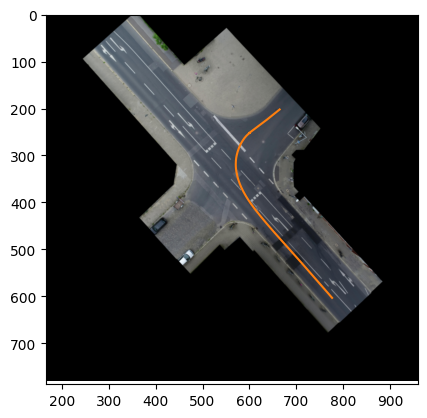

In [167]:
fig, ax = plt.subplots()
plt.plot(SV_x, SV_y)
img   = mpimg.imread(background_filepath)
plt.plot(SV_x/0.00814636091724916/12, -SV_y/0.00814636091724916/12)
plt.imshow(img)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([y_lim_0,y_lim_1])

(np.float64(560.5148120389465),
 np.float64(786.3155021080294),
 np.float64(181.9343393598548),
 np.float64(623.4691489765711))

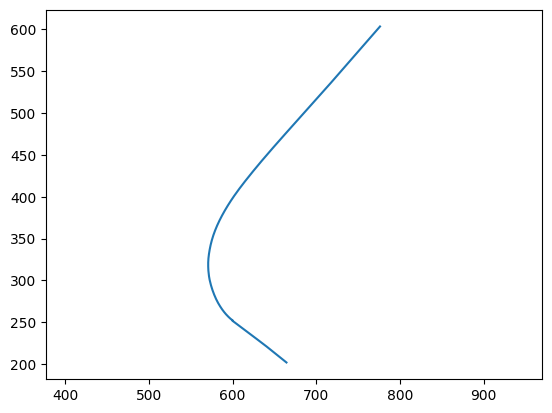

In [164]:
plt.plot((SV_x)/0.00814636091724916/12, -SV_y/0.00814636091724916/12)
plt.axis('equal')